# Predicting the outcome of loan applications
# 4. Model comparison
To get a more complete picture of the performance of the two models, we can compare their precision-recall curves. Precision and recall can always be traded off, so just looking at the numbers for the standard value of the classification threshold of 0.5 is not really enough.

As mentioned before, in this problem we care about high recall (as few false negatives as possible), so the curves below show how we can drive the model towards that, and also how precision will be affected in the process. The strategy to implement will ultimately be driven by business strategy: how much risk are we willing to take to achieve a given target revenue?

Both models are doing better than random guessing, and the Random Forest model is doing better than Logistic Regression.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

from shared.data_processing import CategoricalEncoder
from shared.data_processing import FeatureSelector
from shared.plotting import compute_precision_recall_curve
from shared.plotting import avg_confusion_matrix


## Load data

In [2]:
df = pd.read_csv('./data/loan_data_prepped.csv')

In [3]:
X = df.drop(['label', 'accepted'], axis=1)
y = df['label']

## Set the features
Features of interest we have identified in the previous notebooks.

In [4]:
NUMERICAL_FEATURES = ['duration', 'loan_amount', 'age']

FIXED_CATEGORICAL = ['foreign_worker_binary', 'checking_status_ordinal', 'savings_status_ordinal',
                     'employment_ordinal', 'installment_commitment_ordinal']

OTHER_CATEGORICAL = ['loan_history', 'purpose', 'other_parties', 'property_magnitude',
                     'other_payment_plans', 'housing', 'personal_status', 'job']

FEATURES = NUMERICAL_FEATURES + FIXED_CATEGORICAL + OTHER_CATEGORICAL

## Set up the modelling pipelines to compare

In [5]:
encoder = CategoricalEncoder(features_to_encode=OTHER_CATEGORICAL)

In [6]:
selector = FeatureSelector(features_to_select=FEATURES)

In [7]:
logistic_tuned = LogisticRegression(max_iter=2000,
                                    class_weight='balanced',
                                    solver='newton-cg',
                                    C=0.004832930238571752)

In [8]:
pipe_logistic = Pipeline(steps=[('encoder', encoder),
                                ('select', selector),
                                ('scaler', StandardScaler()),
                                ('logistic', logistic_tuned)])

In [9]:
rfc_tuned = RandomForestClassifier(class_weight='balanced',
                                   n_estimators=100,
                                   criterion='gini',
                                   max_depth=7,
                                   max_features=13)

In [10]:
pipe_forest = Pipeline(steps=[('encode', encoder),
                              ('select', selector),
                              ('forest', rfc_tuned)])

## Compare the precision-recall curves

In [11]:
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.25)

In [12]:
(precision_means_rfc, precision_stds_rfc,
 recall_means_rfc, recall_stds_rfc) = compute_precision_recall_curve(X, y, pipe_forest, sss)

In [13]:
(precision_means_lr, precision_stds_lr,
 recall_means_lr, recall_stds_lr) = compute_precision_recall_curve(X, y, pipe_logistic, sss)

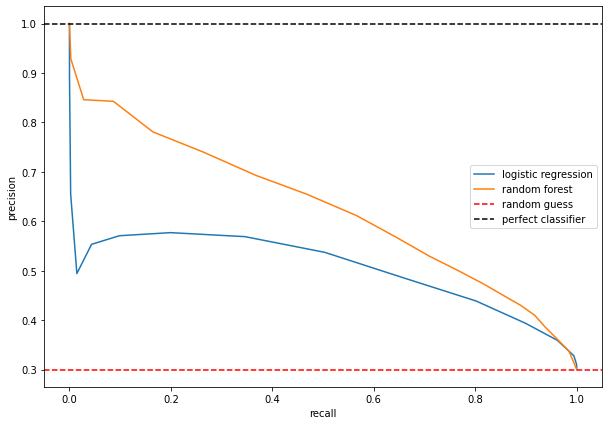

In [14]:
fig = plt.figure(figsize=(10, 7))

plt.plot(recall_means_lr, precision_means_lr)
plt.plot(recall_means_rfc, precision_means_rfc)

plt.axhline(y=y.mean(), color='red', linestyle='dashed')
plt.axhline(y=1, color='black', linestyle='dashed')

plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(['logistic regression', 'random forest', 'random guess', 'perfect classifier'])

## Random Forest Confusion Matrix

In [15]:
means, stds = avg_confusion_matrix(X, y, pipe_forest, sss, threshold=0.32)


In [16]:
means

array([[0.398  , 0.302  ],
       [0.04852, 0.25148]])

In [17]:
stds

array([[0.02268039, 0.02268039],
       [0.01377133, 0.01377133]])

## Random Forest Feature Importances

In [18]:
rfc_tuned.feature_importances_

array([0.08956389, 0.12481837, 0.10755564, 0.0093971 , 0.23283854,
       0.079704  , 0.0447259 , 0.03060594, 0.05608676, 0.06263241,
       0.03464301, 0.03561938, 0.04024985, 0.01113511, 0.02194527,
       0.01847883])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

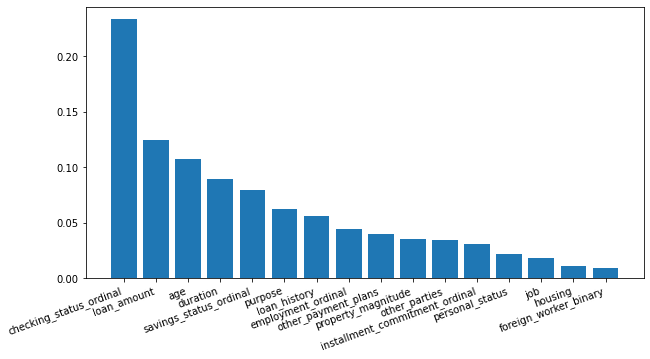

In [19]:
fig = plt.figure(figsize=(10, 5))

IDX = np.argsort(-rfc_tuned.feature_importances_)

plt.bar(np.asarray(FEATURES)[IDX], rfc_tuned.feature_importances_[IDX])
plt.xticks(rotation=20, ha='right')
